# Analiza wyjaśnialności cech

In [2]:
import sys
sys.path.append('../.') 

from srai.regionalizers import H3Regionalizer, geocode_to_region_gdf
from srai.embedders import CountEmbedder
from src.embedders.osm_data_embedder import OSMDataEmbedder

import pandas as pd
import geopandas as gpd

from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

#### Dane

Wczytanie danych i wygenerowanie zapytania dotyczącego OSM, aby uzyskać cechy geoprzestrzenne związane z drogą (highway_xyz).

In [3]:
area = geocode_to_region_gdf("Wrocław, Poland")
regionalizer = H3Regionalizer(resolution=8)
embedder = CountEmbedder()
query = {"highway": True}

embeddings = OSMDataEmbedder(area=area, embedder=embedder, regionalizer=regionalizer, query=query)
embeddings_feature_gdf = embeddings.make_embeddings()

In [4]:
df_accidents = pd.read_csv('../data/embeddings.csv')
gdf = pd.merge(df_accidents, embeddings_feature_gdf, on='region_id', how='inner')

In [5]:
features_list_all_highway = gdf.columns[len(df_accidents.columns)+1:].to_list()

Wcześniej wybrane przez nas wartości: 
- 'highway_bridleway',
- 'highway_bus_stop',
- 'highway_elevator',
- 'highway_give_way',
- 'highway_motorway',
- 'highway_passing_place',
- 'highway_primary_link',
- 'highway_secondary_link',
- 'highway_stop',
- 'highway_traffic_signals',
- 'highway_turning_ circle'

In [6]:
# selected_features = ['highway_bridleway',
#  'highway_bus_stop',
#  'highway_elevator',
#  'highway_give_way',
#  'highway_motorway',
#  'highway_passing_place',
#  'highway_primary_link',
#  'highway_secondary_link',
#  'highway_stop',
#  'highway_traffic_signals',
#  'highway_turning_ circle']

In [7]:
selected_features = features_list_all_highway

Poniej przypisanie poziomów ryzyka na podstawie wartości kolumny 'rok_2023' w DataFrame gdf oraz przyporządkowanie wartości numerycznych do kolumny 'risk_level'.

In [8]:
bins = [-1, 0, 2, 12, float("inf")]
label_names = ['no risk', 'low risk', 'medium risk', 'high risk']
gdf['risk_level'] = pd.cut(gdf['rok_2023'], bins=bins, labels=label_names, right=True)

custom_mapping = {
    'no risk': 0,
    'low risk': 1,
    'medium risk': 2,
    'high risk': 3
}

gdf['risk_level_numeric'] = gdf['risk_level'].map(custom_mapping)

gdf= gdf.set_index('region_id')
gdf = gdf.drop(['rok_2023'], axis=1)

gdf_base = gdf[['geometry'] + selected_features + ['risk_level_numeric']]
gdf_base.head()

,geometry,highway_bridleway,highway_bus_stop,highway_construction,highway_corridor,highway_crossing,highway_cycleway,highway_elevator,highway_footway,highway_give_way,...,highway_tertiary_link,highway_track,highway_traffic_mirror,highway_traffic_signals,highway_trunk,highway_trunk_link,highway_turning_circle,highway_turning_loop,highway_unclassified,risk_level_numeric
region_id,,,,,,,,,,,,,,,,,,,,,
881e204059fffff,"POLYGON ((16.95106 51.14480, 16.94865 51.14052...",0,5,0,0,48,77,0,291,0,...,0,20,0,4,0,0,1,0,0,3
881e205561fffff,"POLYGON ((16.95215 51.20788, 16.94974 51.20361...",0,0,0,0,0,0,0,0,0,...,0,16,0,0,0,0,0,0,0,0
881e2041ddfffff,"POLYGON ((16.96256 51.07951, 16.97006 51.08058...",0,5,0,0,21,7,0,128,0,...,0,8,0,0,0,0,3,0,0,2
881e204225fffff,"POLYGON ((16.89344 51.14051, 16.90094 51.14158...",0,6,0,0,16,6,0,163,0,...,0,7,0,0,0,0,3,0,0,2
881e2050a1fffff,"POLYGON ((16.87946 51.20145, 16.88455 51.19824...",0,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,0,0,0


#### Analiza korelacji między wybranymi cechami a poziomem ryzyka

Obliczenie macierzy korelacji między wybranymi cechami a kolumną 'risk_level' (poziomem ryzyka).

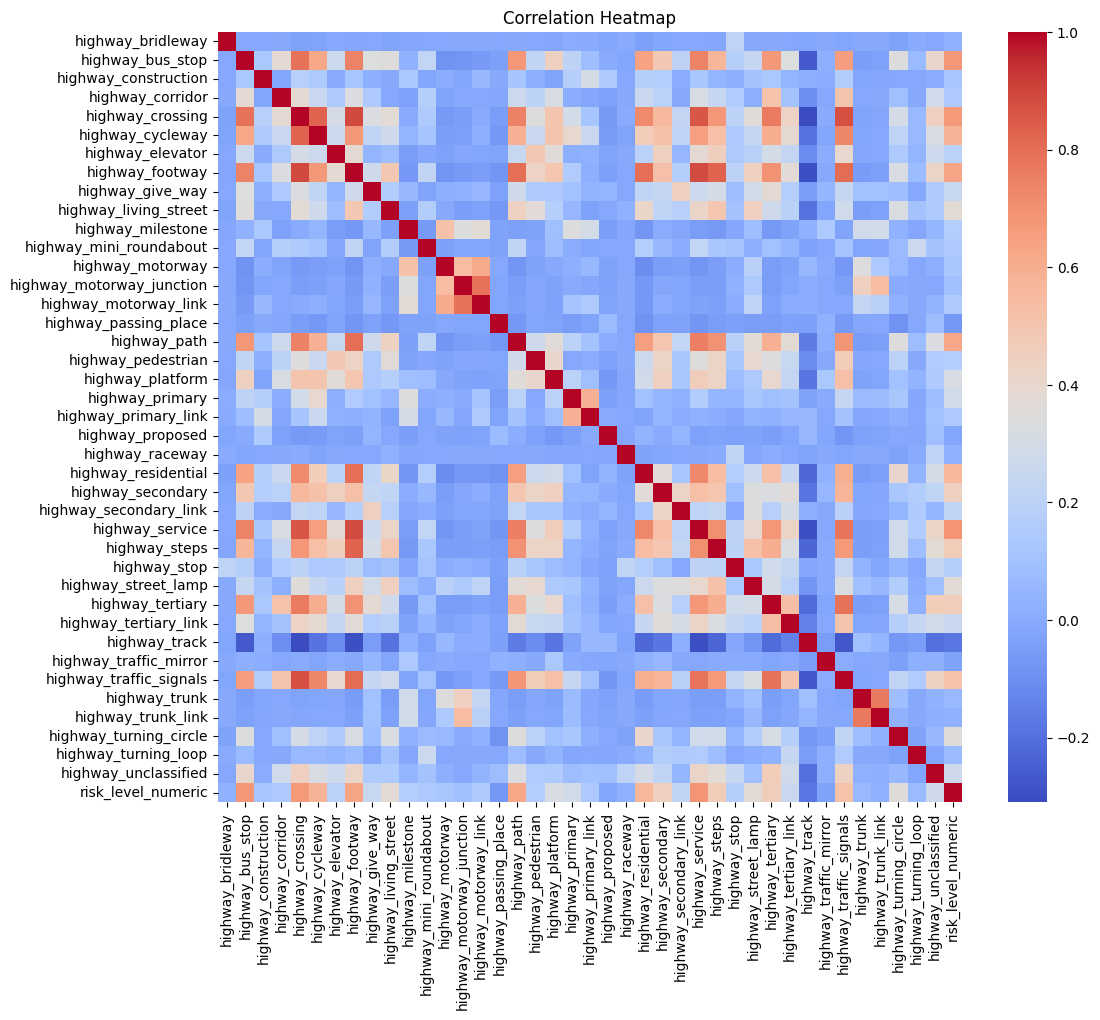

In [9]:
correlation_matrix = gdf_base[selected_features + ['risk_level_numeric']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


Wybór korelacji z risk_level powyżej 0.5 lub poniżej -0.5 dla analizy.

In [10]:
correlation_matrix_all = gdf_base[features_list_all_highway + ['risk_level_numeric']].corr()

correlation_matrix_all[
    (correlation_matrix_all['risk_level_numeric'] > 0.5) | (correlation_matrix_all['risk_level_numeric'] < -0.5)
]

,highway_bridleway,highway_bus_stop,highway_construction,highway_corridor,highway_crossing,highway_cycleway,highway_elevator,highway_footway,highway_give_way,highway_living_street,...,highway_tertiary_link,highway_track,highway_traffic_mirror,highway_traffic_signals,highway_trunk,highway_trunk_link,highway_turning_circle,highway_turning_loop,highway_unclassified,risk_level_numeric
highway_bus_stop,-0.009875,1.000000,0.131693,0.384948,0.788448,0.622152,0.266582,0.743731,0.344273,0.353306,...,0.342676,-0.264303,0.022190,0.659035,-0.044611,-0.035111,0.350193,0.068152,0.402350,0.679306
highway_crossing,-0.028965,0.788448,0.177608,0.381209,1.000000,0.829273,0.302434,0.891425,0.334486,0.373403,...,0.431953,-0.309598,-0.000651,0.874395,-0.026167,-0.017149,0.300608,0.058947,0.450132,0.668222
highway_cycleway,-0.024946,0.622152,0.142077,0.251564,0.829273,1.000000,0.268394,0.677245,0.212511,0.278528,...,0.386462,-0.189798,-0.021052,0.731276,-0.021342,-0.010036,0.209646,0.063838,0.319766,0.581538
highway_footway,-0.017571,0.743731,0.119375,0.332571,0.891425,0.677245,0.381126,1.000000,0.277098,0.496699,...,0.367606,-0.296480,-0.007562,0.804981,-0.056276,-0.041611,0.320718,0.072163,0.421311,0.635671
highway_path,-0.005644,0.680313,0.113411,0.266213,0.744679,0.593897,0.245219,0.798779,0.277955,0.437981,...,0.377012,-0.162274,0.015165,0.683359,-0.052001,-0.042785,0.350505,0.075277,0.332338,0.628492
highway_residential,-0.039929,0.643018,0.173868,0.254790,0.723578,0.467432,0.195526,0.795536,0.215140,0.414109,...,0.240417,-0.222888,0.031823,0.600780,-0.054441,-0.041170,0.404529,0.036737,0.300127,0.565649
highway_service,-0.011806,0.743718,0.125372,0.317934,0.858351,0.654518,0.385764,0.884922,0.272281,0.421310,...,0.424790,-0.298250,-0.009616,0.782670,-0.046114,-0.040656,0.279824,0.153347,0.417982,0.689664
highway_traffic_signals,-0.022532,0.659035,0.162294,0.511612,0.874395,0.731276,0.398335,0.804981,0.234496,0.282889,...,0.509250,-0.278430,0.004524,1.000000,-0.022968,-0.012309,0.217986,0.151461,0.439839,0.517605
risk_level_numeric,0.031276,0.679306,0.119922,0.139539,0.668222,0.581538,0.196072,0.635671,0.244475,0.379323,...,0.253157,-0.171595,-0.028631,0.517605,0.062684,0.032064,0.359714,0.066020,0.274547,1.000000


Interpretacja:
* Wartości bliskie 1 oznaczają silną pozytywną korelację (wzrost jednej cechy skutkuje wzrostem drugiej).
* Wartości bliskie -1 oznaczają silną negatywną korelację (wzrost jednej cechy skutkuje spadkiem drugiej).
* Wartości bliskie 0 oznaczają brak korelacji.

Wybieramy cechy związane z drogami, które są silnie skorelowane (zarówno dodatnio, jak i ujemnie) z poziomem ryzyka. Jako 'silną' korelację uznajemy wartości powyżej 0.5 lub poniżej -0.5.

In [11]:
best_features = correlation_matrix_all['risk_level_numeric'][(correlation_matrix_all['risk_level_numeric'] < -0.5) | (correlation_matrix_all['risk_level_numeric'] > 0.5)].index.to_list()
best_features.remove('risk_level_numeric')
print(best_features)

['highway_bus_stop', 'highway_crossing', 'highway_cycleway', 'highway_footway', 'highway_path', 'highway_residential', 'highway_service', 'highway_traffic_signals']


Tworzymy nową macierz korelacji dla najlepszych cech związanych z drogami (best_features) i poziomu ryzyka.

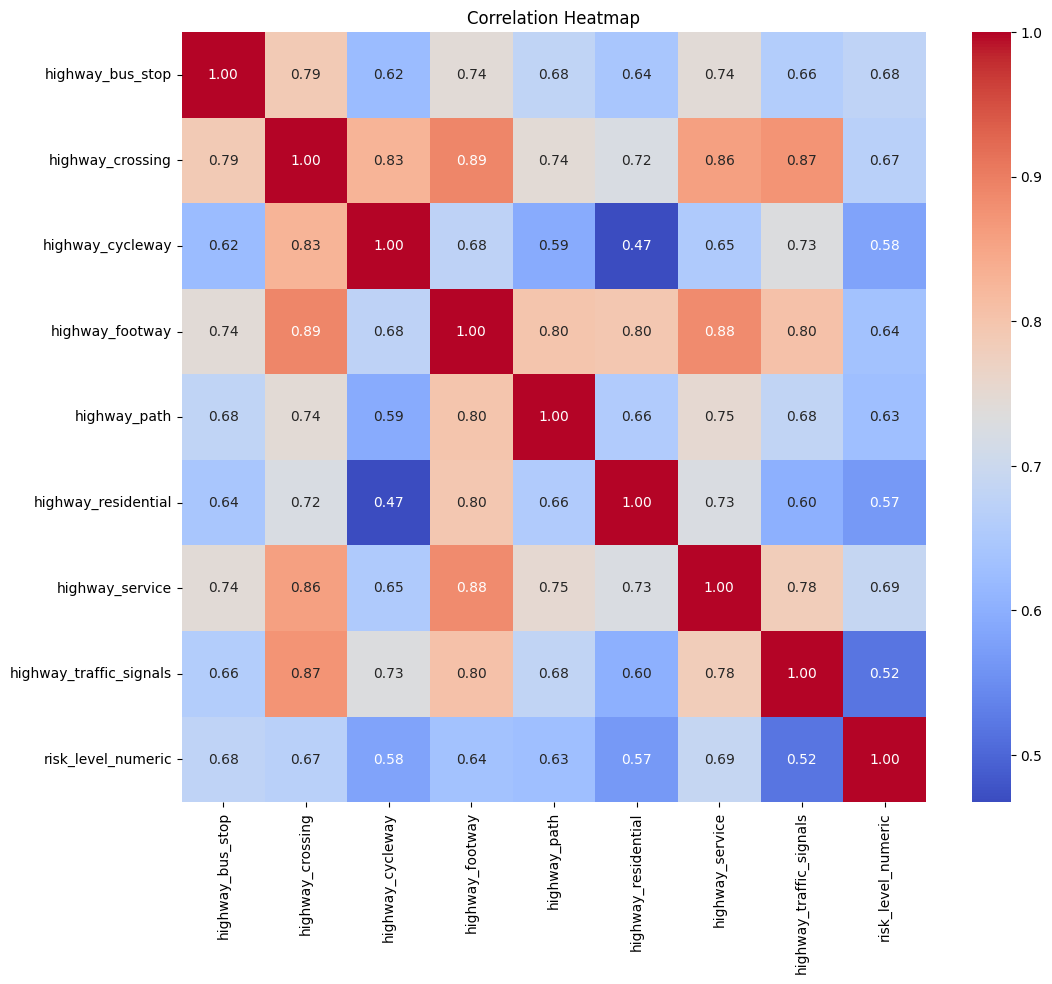

In [12]:
correlation_matrix_best_features = gdf_base[best_features + ['risk_level_numeric']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_best_features, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

#### Wnioski

* Analiza macierzy korelacji wybranych cech związanych z drogami a poziomem ryzyka wypadków drogowych wykazała istotne zależności. Wśród najlepszych cech silnie skorelowanych z poziomem ryzyka znalazły się m.in. obecność przystanków autobusowych, przejść dla pieszych oraz sygnalizacji świetlnej. 

* Wartości korelacji dla poziomu ryzyka z poszczególnymi rodzajami dróg spośród 9 najsilniej skorelowanych z poziomem ryzyka (corr < -0.5) wahają się między 0.52 a 0.69.
Korelacje te są umiarkowane do silnie pozytywnych. Sugeruje to, że obszary z tymi rodzajami dróg mogą być bardziej narażone na ryzyko wypadków drogowych.

* Korelacje między rodzajami dróg: Wśród rodzajów dróg występują silne korelacje pozytywne, co oznacza, że obszary z większą ilością pewnego rodzaju drogi mają tendencję do posiadania także innych rodzajów dróg. Na przykład, 'highway_crossing' silnie koreluje z 'highway_service' (0.86), co wskazuje na to, że obszary z dużą ilością przejść dla pieszych mają również dużo obszarów usługowych.

___

## SHAP

Wartości Shapley są używane do interpretacji modelu i wyjaśnienia, jakie wpływy mają poszczególne cechy na predykcje modelu dla konkretnych obserwacji.

W przypadku problemu klasyfikacji binarnej (jak w przypadku modelu regresji logistycznej), wartości Shapley dla danej cechy dla konkretnej obserwacji wyjaśniają, jak ta cecha przyczynia się do różnicy między przewidywaną klasą a wartością bazową modelu. Wartość bazowa to oczekiwana wartość modelu dla danej obserwacji, uwzględniająca wpływ wszystkich cech.
Pozytywna wartość Shapley oznacza zwiększenie wyniku, a wartość negatywna oznacza zmniejszenie wyniku.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import shap

In [20]:
y = gdf_base['risk_level_numeric']
X = gdf_base[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_lr = LogisticRegression(max_iter=10000)
linear_lr.fit(X_train, y_train)

#Przygotowanie przybliżonej próbki tła za pomocą metody k-means.
background_summary = shap.kmeans(X_train, 100)

explainer = shap.KernelExplainer(linear_lr.predict_proba, background_summary)

#Obliczenie SHAP wartości dla danych testowych (X_test), co pozwala na zrozumienie, jak każda zmienna przyczynia się do przewidywanej wartości.
shap_values = explainer.shap_values(X_test)

  0%|          | 0/85 [00:00<?, ?it/s]

shap.summary_plot generuje wykres podsumowujący wpływ poszczególnych cech na predykcje modelu na podstawie SHAP.

Interpretacja:
- Długość poziomego słupka odzwierciedla wpływ danej cechy na predykcję modelu.
- Słupki są kolorowane w zależności od wartości danej cechy dla danego obserwacji.
- Wartości na ośi X (poziomej) reprezentują sumaryczny wpływ cechy na predykcję modelu.
- Wartość mean(|SHAP|) reprezentuje średnią wartość bezwzględną ze wszystkich wartości SHAP dla danego przypadku testowego lub dla całego zestawu danych.

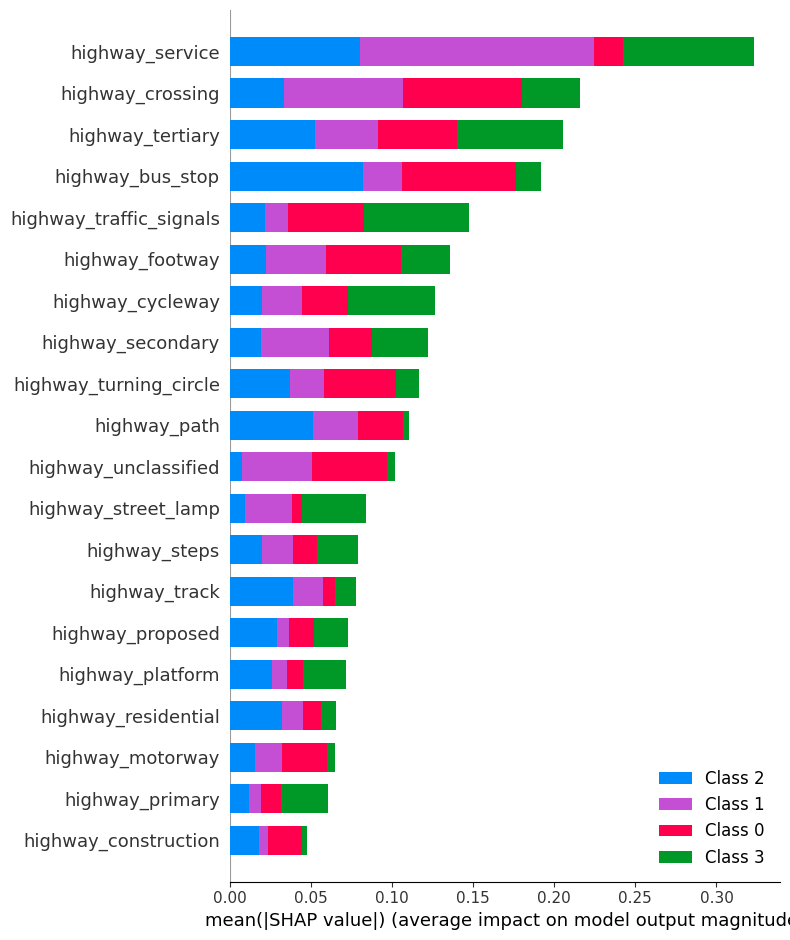

In [21]:
shap.summary_plot(shap_values, X_test)

Wykres podsumowujący pokazuje, które cechy mają największy wpływ na wyniki modelu na zbiorze testowym, widzimy, ze są to m.in. (od mających największy wpływ na wyniki modelu): 
- highway_service
- highway_crossing
- highway_tertiary
- highway_bus_stop
- highway_traffic_signals
- highway_footway
- highway_cycleway
- highway_secondary
- highway_turning_circle
- highway_path
- highway_unclassified

Wartości SHAP w zakresie od 0.10 do 0.35 są umiarkowane, co oznacza, że analizowane cechy mają znaczący, ale nie dominujący wpływ na predykcje modelu.


Funkcja shap.force_plot generuje interaktywny wykres, który pozwala zobaczyć, jak poszczególne zmienne wpływają na wynik modelu dla konkretnego przypadku. 

Ponizej generujemy wykres force_plot i zapisujemy jako plik html (nalezy otworzyc osobno, poniewaz w notebooku jest nieczytelny).

Interpretacja wykresu force_plot:
- Górne liczby na osi x to indeksy danych próbkowych. Niebieski pas to cechy i o ile obniżają ostateczną wartość wyjściową (do klasy 0), a różowe pasy to te, które ją zwiększają (do klasy 3).

In [22]:
shap.initjs()
p = shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)
shap.save_html('force_plot_all_features.html', p)


### best features (corr < -0.5 | corr > 0.5)

Ponizej analiza wartości Shapley dla wcześniej wyznaczonych cech z najśliniejszą korelacją z risk_level.

In [25]:
y = gdf_base['risk_level_numeric']
X = gdf_base[best_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_lr = LogisticRegression(max_iter=1000)
linear_lr.fit(X_train, y_train)

background_summary = shap.kmeans(X_train, 100)
explainer = shap.KernelExplainer(linear_lr.predict_proba, background_summary)

shap_values = explainer.shap_values(X_test)

  0%|          | 0/85 [00:00<?, ?it/s]

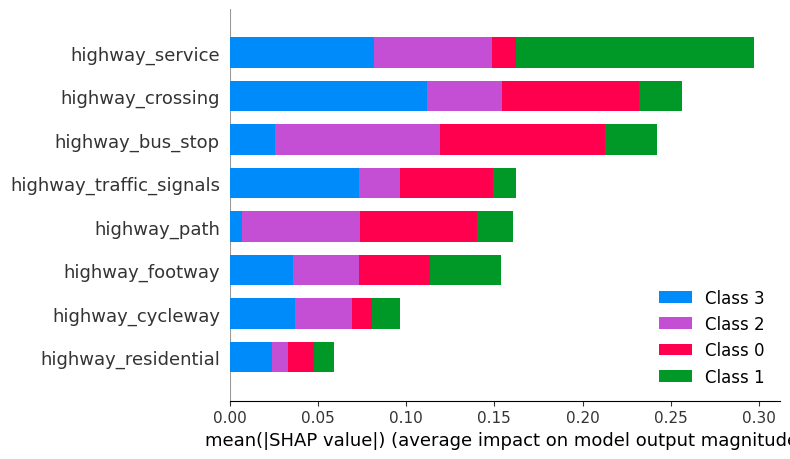

In [26]:
shap.summary_plot(shap_values, X_test)

In [27]:
shap.initjs()
p = shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)
shap.save_html('force_plot_best_features.html', p)

#### wnioski

Porównanie wpływu na model i korelacji z poziomem ryzyka:

Widzimy, że cechy, które mają największy wpływ na model, często pokrywają się z tymi, które są silnie skorelowane z poziomem ryzyka. Oznacza to, że te cechy istotnie przyczyniają się do predykcji modelu dotyczącej poziomu ryzyka. Dla przykładu, highway_service ma duży wpływ na predykcję modelu i jest jednocześnie silnie skorelowane z poziomem ryzyka.

Najistotniejsze cechy na bazie dokonanej analizy:
- highway_service
- highway_crossing
- highway_tertiary
- highway_bus_stop
- highway_traffic_signals
- highway_footway
- highway_cycleway
- highway_secondary
- highway_turning_circle
- highway_path
- highway_unclassified
- highway_residential
